In [1]:
import os
import sys
import glob
import re

import warnings
warnings.filterwarnings("ignore")

from pyprojroot.here import here

sys.path.insert(1, str(here('bin')))
from customPythonFunctions import generate_split_dir

import matplotlib
import pandas as pd
import scanpy as sc
import anndata as ad

overwriteData = True
overwriteFigure = True

# Directory where the notebook is stored
currDir = os.getcwd()

In [2]:
# SANKEY DIAGRAM FUNCTION EDIT FROM:
# https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0

def genSankey(df,cat_cols=[], colors = 'Set1', value_cols='',title='Sankey Diagram', size = 10):
    # maximum of 6 value cols -> 6 colors
    #colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))

    if isinstance(colors, list):
        colorPalette = colors
    else:
        nCol = len(cat_cols)
        cmap = matplotlib.colormaps.get_cmap(colors)
        colorPalette = ['#{:02x}{:02x}{:02x}'.format(round(cmap(c/nCol)[0]*255), round(cmap(c/nCol)[1]*255), round(cmap(c/nCol)[2]*255)) for c in range(nCol)]

    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))

    labelList = [re.sub(r'\([^)]*\)', '', l) for l in labelList]
    labelList = [l.replace('_', ' ') for l in labelList]
    
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = size
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

# Retrieve pandas dataframes with annotations

**Loading pandas dataFrame**

In [3]:
fullAnnotationDF = pd.read_pickle(here('02_cell_annotation/SCGT00_CentralizedDataset/02_fromCellLineages_to_CellTypes/master_clusterAnnotDF_final.pkl'))
fullAnnotationDF.head()

,annotation_step_1,annotation_step_2,annotation_step_3,Level1
cellID,,,,
SCGT00_L051_I53.3P_T0_AACCAACGTGGGATTG,pDC,pDC,pDC,pDC
SCGT00_L051_I51.3P_T0_AAGGTAATCTTCCCGA,pDC,pDC,pDC,pDC
SCGT00_L051_I58.3P_T0_ACCTGAAAGTGCCAGA,pDC,pDC,pDC,pDC
SCGT00_L051_I51.3P_T0_ACGGGTCTCTTGGTGA,pDC,pDC,pDC,pDC
SCGT00_L051_I53.3P_T0_ACTATGGAGGCGCTCT,pDC,pDC,pDC,pDC


In [4]:
fullAnnotationDF.value_counts(['Level1'], dropna=False)

Level1          
T_CD4_NonNaive      159203
Mono                131392
T_CD4_Naive         123116
T_CD8_NonNaive       93256
LowQuality_cells     61139
ILC                  57046
B                    55869
Platelets            52472
T_CD8_Naive          40745
Doublets_Step1       34797
UTC                  23420
DC                   10440
Doublets_Step2        3361
pDC                   3125
Cycling               2741
Progenitors           1716
Plasma                1383
RBC                    196
Name: count, dtype: int64

# Loading single-cell data

**Scanpy object with count raw and normalized**

In [8]:
adata = sc.read_h5ad(here("01_data_processing/SCGT00_CentralizedDataset/results/2_SCGT00_MAIN_normalized.h5ad"))
adata

AnnData object with n_obs × n_vars = 855417 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'counts', 'log1

**Import annotation**

In [9]:
adata.obs = adata.obs.merge(fullAnnotationDF[['Level1']], left_index=True, right_index=True, how='left')

# Remove discarded cells

We also check the distribution of the number of cells in each cell-types among patient and disease.

In [10]:
adataFilt = adata[~adata.obs['Level1'].isin(['Doublets_Step1', 'Doublets_Step2','LowQuality_cells']),:].copy()
adataFilt

AnnData object with n_obs × n_vars = 756120 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase', 'Level1'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'coun

In [11]:
del adata

In [12]:
patientXdisease = pd.DataFrame(adataFilt.obs[['sampleID','disease']].drop_duplicates().value_counts('disease')).reset_index()
patientXdisease.columns = ['disease','tot_patient']
patientXdisease

,disease,tot_patient
0,RA,64
1,PS,24
2,PSA,24
3,CD,16
4,UC,16
5,SLE,8


In [13]:
adataFilt.obs['sampleID'].unique().shape

(152,)

In [14]:
print(sorted(set(adataFilt.obs.Level1.unique().tolist())))

['B', 'Cycling', 'DC', 'ILC', 'Mono', 'Plasma', 'Platelets', 'Progenitors', 'RBC', 'T_CD4_Naive', 'T_CD4_NonNaive', 'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC']


In [15]:
cellTypeXpatient = pd.DataFrame(adataFilt.obs.groupby(['Level1','sampleID'], observed = False).size()).reset_index()
cellTypeXpatient.columns = ['Level1','sampleID','Count']
cellTypeXpatient.sort_values('Count')
cellTypeXpatient = cellTypeXpatient.merge(adataFilt.obs[['sampleID','disease']].drop_duplicates(), on='sampleID', how='left') 
cellTypeXpatient

,Level1,sampleID,Count,disease
0,B,SCGT00_I51.3P_T0,553,RA
1,B,SCGT00_I52.3P_T0,812,RA
2,B,SCGT00_I53.3P_T0,116,RA
3,B,SCGT00_I54.3P_T0,234,RA
4,B,SCGT00_I55.3P_T0,459,RA
...,...,...,...,...
2275,pDC,SCGT00val_I036027_T0,11,RA
2276,pDC,SCGT00val_I036028_T0,23,RA
2277,pDC,SCGT00val_I036030_T0,4,RA
2278,pDC,SCGT00val_I036031_T0,17,RA


In [16]:
threshold = 5
patient_with_no_cellTypes = cellTypeXpatient.query('Count < @threshold')[['Level1','sampleID','disease']].groupby(['Level1','disease'], observed = True).count().reset_index().merge(patientXdisease, on='disease', how='left')
patient_with_no_cellTypes['proportion']  = patient_with_no_cellTypes['sampleID'] / patient_with_no_cellTypes['tot_patient']
patient_with_no_cellTypes.loc[~patient_with_no_cellTypes['Level1'].isin(['RBC','Progenitors','Platelets','Plasma']),:].sort_values('proportion', ascending=False)

,Level1,disease,sampleID,tot_patient,proportion
28,pDC,SLE,4,8,0.500000
29,pDC,UC,5,16,0.312500
4,Cycling,SLE,2,8,0.250000
2,Cycling,PSA,4,24,0.166667
27,pDC,RA,9,64,0.140625
3,Cycling,RA,6,64,0.093750
25,pDC,PS,2,24,0.083333
26,pDC,PSA,2,24,0.083333
0,Cycling,CD,1,16,0.062500
5,DC,UC,1,16,0.062500


As you can see, we annotated a very few number of pDC / Cycling cells. Some patients show less than 5 cell.

**Cleaning object to keep only relevant fields for the next steps**

In [19]:
adataFilt.obs.drop(['timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'age', 'BMI', 'technology', 'patientID',
                     'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 
                     'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 
                     'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
                     'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 
                     'pct_counts_plt', 'S_score', 'G2M_score', 'phase'],
                    axis=1,inplace=True)
adataFilt.var.drop(['mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 
                         'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'],axis=1, inplace=True)

In [20]:
adataFilt.X = adataFilt.layers['counts'].copy()

In [21]:
del adataFilt.layers
del adataFilt.uns

In [22]:
adataFilt

AnnData object with n_obs × n_vars = 756120 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'batches', 'Level1'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

# Saving object

In [23]:
if overwriteData:
    adataFilt.write(here('02_cell_annotation/SCGT00_CentralizedDataset/02_fromCellLineages_to_CellTypes/SCGT00_MAIN_annotated_LowQFilt.h5ad'), compression='gzip')

## Data exploring

In [25]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import plotly.io as pio

# Import functions
sys.path.insert(1, str(here('bin')))
from customPalette import *

dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

In [4]:
adataFilt = ad.read_h5ad(here('02_cell_annotation/SCGT00_CentralizedDataset/02_fromCellLineages_to_CellTypes/SCGT00_MAIN_annotated_LowQFilt.h5ad'))
adataFilt

AnnData object with n_obs × n_vars = 4435922 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [26]:
obs_df = adataFilt.obs
obs_df['Level1'] = pd.Categorical(obs_df['Level1'], categories=annotation_Level1_LowQFilt_sortednames)

In [27]:
agg_data = obs_df.groupby(['disease', 'Level1']).size().unstack(fill_value=0)
agg_data = agg_data.div(agg_data.sum(axis=1), axis=0) * 100  # Calculate percentages

agg_data.index = agg_data.index.astype(str)
agg_data = agg_data.reindex(disease_sortednames)
agg_data.head()

Level1,B,Plasma,pDC,DC,Mono,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,ILC,Cycling_cells,Progenitors,Platelets,RBC
disease,,,,,,,,,,,,,,,
RA,6.845165,0.171477,0.323648,1.250873,17.250748,16.477115,21.826683,4.642085,12.258044,3.396038,8.197675,0.0,0.207532,7.123673,0.029242
PS,8.472204,0.088912,0.427836,1.257098,15.125666,19.556318,23.249263,6.098860,7.949294,3.089044,8.234517,0.0,0.286104,6.158722,0.006162
PSA,8.874690,0.169227,0.664602,1.682017,21.178027,15.275584,19.905233,5.240918,9.209042,3.103526,8.754692,0.0,0.214355,5.689114,0.038974
CD,6.276644,0.225064,0.673869,1.877300,16.935420,15.765086,20.913761,5.919189,13.950009,2.815950,5.667646,0.0,0.276697,8.679535,0.023830
UC,6.817922,0.295736,0.247779,1.442143,14.928407,14.343785,19.321062,6.044897,21.416337,2.964215,5.623558,0.0,0.188403,6.332641,0.033113


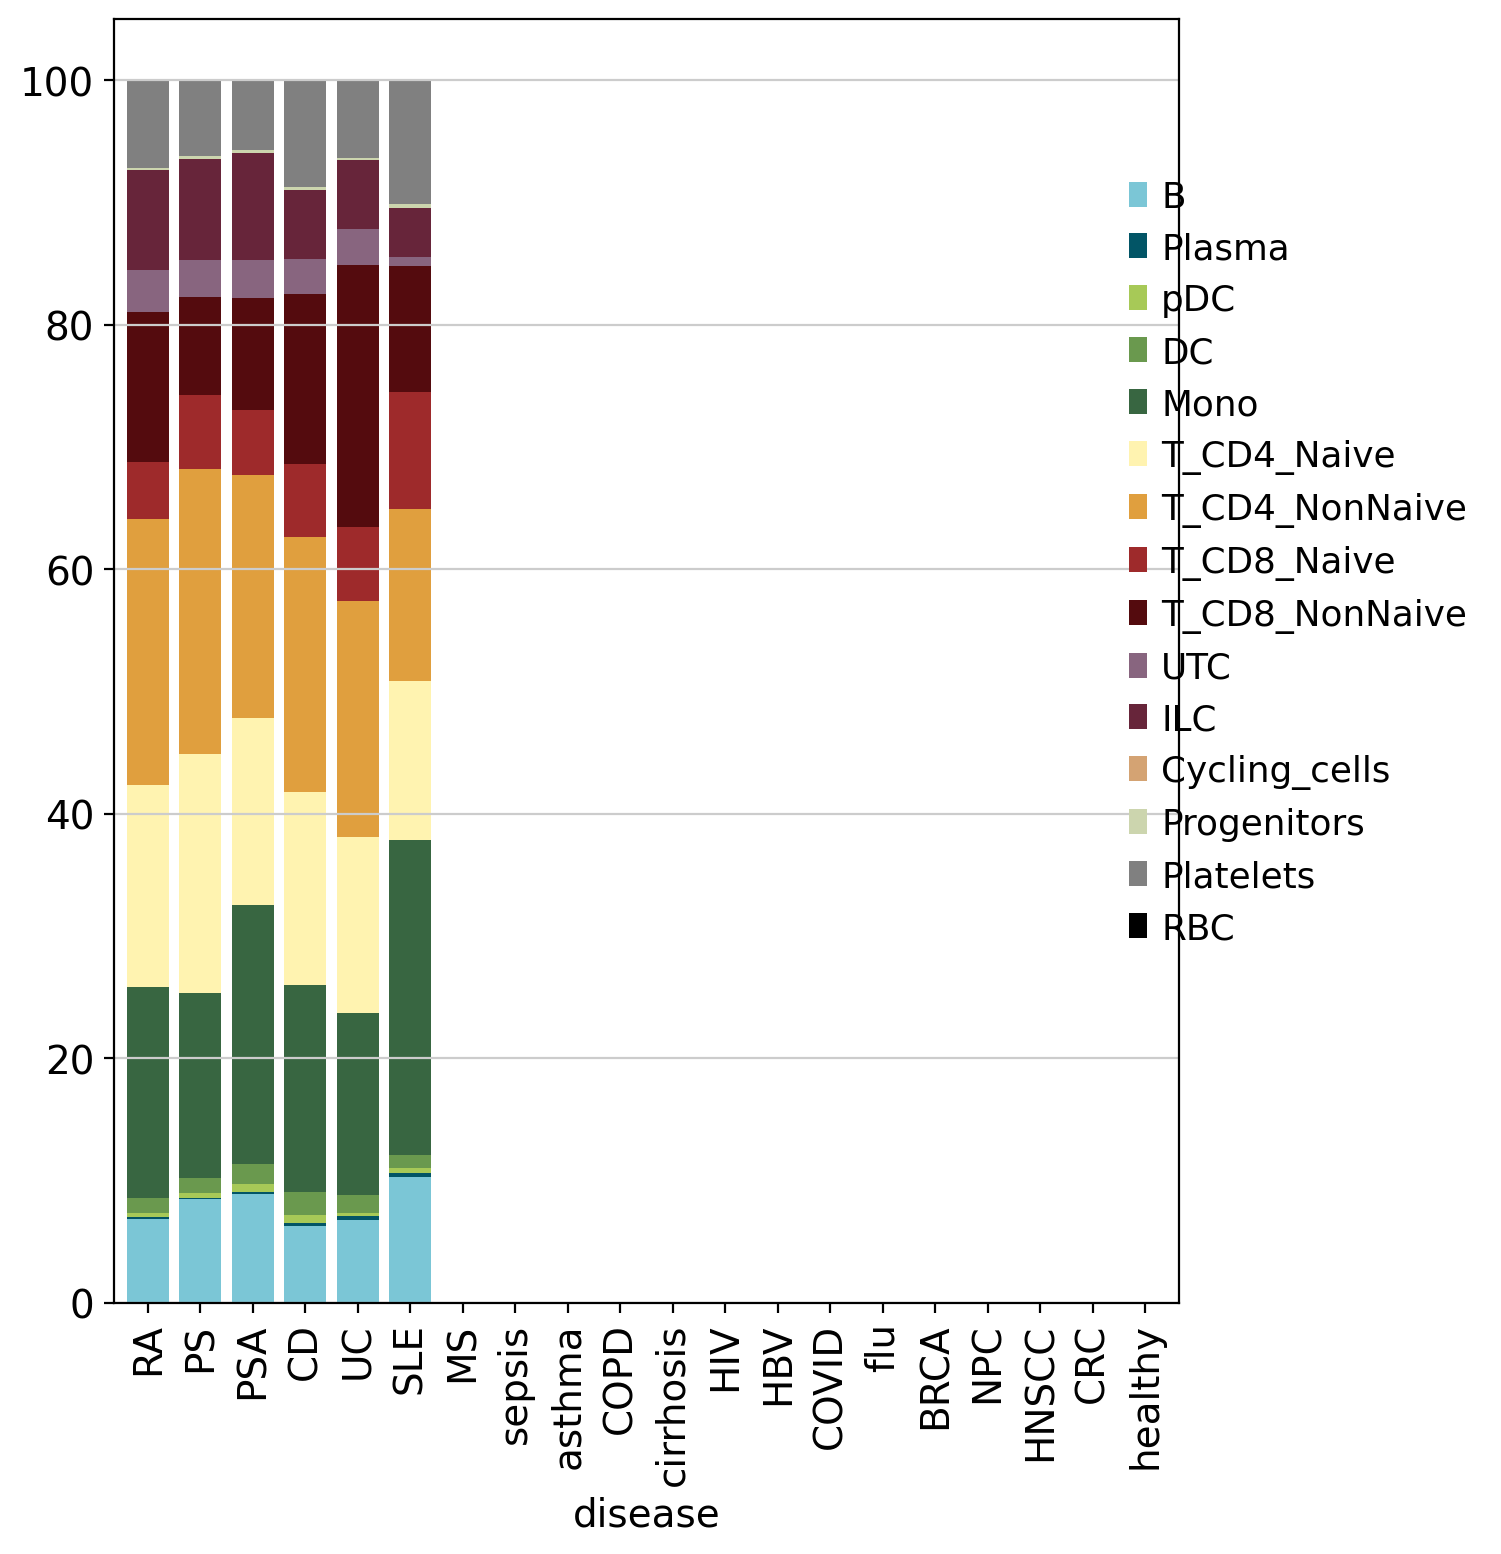

In [28]:
# Plotting the stacked bar plot

fig, ax = plt.subplots(figsize=(8, 8))
agg_data.plot(kind='bar', stacked=True, color=annotation_Level1_palette, width=0.8, ax=ax)

# Adding labels and title
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.3, 0.9), ncol=1, frameon=False)
plt.tight_layout()

plt.savefig(here(f"02_cell_annotation/SCGT00_CentralizedDataset/02_fromCellLineages_to_CellTypes/figures/MAINdata_Level1Proportions_overview.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

plt.show()